In [1]:
import os
import pandas as pd
from autoemulate.core.compare import AutoEmulate
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis
from ModularCirc import BatchRunner
import torch
figsize = (9, 5)

In [2]:
param_filename = 'parameters_naghavi_constrained_fixed_T_v_tot_v_ref'

n_samples = 2048

simulation_out_path = f'../outputs/simulations/output_{n_samples}_samples_{param_filename}/'

parameters_json_file = os.path.join(simulation_out_path, 'parameters.json')

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(simulation_out_path, f'input_samples_{n_samples}.csv'))

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(simulation_out_path, f'simulations_summary.csv'))

output_to_emulate = 'p_ao_max'

In [3]:
# Use ModularCirc's BatchRunner to condense parameter names. This requires setting up the sampler first.
br = BatchRunner()

br.setup_sampler(parameters_json_file)

br._parameters_2_sample

{'ao.r': (195.0, 325.0),
 'ao.c': (0.22499999999999998, 0.375),
 'art.r': (843.75, 1406.25),
 'art.c': (2.25, 3.75),
 'ven.r': (6.75, 11.25),
 'ven.c': (84.975, 141.625),
 'av.r': (4.5, 7.5),
 'mv.r': (3.0749999999999997, 5.125),
 'la.E_pas': (0.22499999999999998, 0.375),
 'la.E_act': (0.41250000000000003, 0.6875),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.75, 1.25),
 'lv.E_act': (2.25, 3.75),
 'lv.k_pas': (0.00999, 0.045)}

In [4]:
# Get column names for parameters up to 'lv.k_pas'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('lv.k_pas') + 1])

input_params[parameter_names]

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.k_pas,lv.E_pas,lv.E_act,lv.k_pas
0,305.576111,0.364705,1047.778645,2.796825,7.379755,116.738799,5.767604,3.872886,0.253016,0.650535,0.067715,1.247329,3.465806,0.038978
1,224.490389,0.267449,1391.318553,3.568193,9.100033,91.786620,6.305379,4.954608,0.372932,0.446568,0.020225,0.806839,2.924290,0.010012
2,254.249478,0.327790,906.121586,2.608205,10.275423,104.035536,5.166425,4.290832,0.334445,0.542466,0.044211,0.985828,3.109324,0.031278
3,271.680109,0.230533,1251.458715,3.003151,8.699872,129.094902,6.925526,3.321711,0.286747,0.613231,0.051136,1.052777,2.523997,0.019900
4,285.041178,0.313907,1283.209757,3.239476,7.965886,122.133654,4.714354,4.508952,0.315288,0.459171,0.036808,1.100807,3.203127,0.017301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,285.121142,0.230828,887.757827,3.491993,10.294631,88.931860,4.651514,4.600824,0.247895,0.525992,0.023380,0.808730,2.320932,0.027869
2044,271.790319,0.313623,1066.858803,3.724367,10.729309,110.072925,6.941766,3.229777,0.349449,0.678943,0.064682,0.856512,3.002628,0.044962
2045,254.213627,0.253792,1266.494987,2.660422,7.945536,134.578851,4.950853,4.310694,0.229570,0.474975,0.030579,1.166408,2.602150,0.016063
2046,224.526976,0.350528,925.493575,3.162989,6.912402,122.320007,6.054582,4.925923,0.263373,0.512817,0.033596,1.094903,3.548719,0.035140


In [5]:
Y = summary_stats[output_to_emulate].values

In [6]:
# Turn x into a pytorch tensor
x = torch.tensor(input_params[parameter_names].values, dtype=torch.float32)

# Do the same with Y
y = torch.tensor(Y, dtype=torch.float32)

In [7]:
print(x.shape, y.shape)

torch.Size([2048, 14]) torch.Size([2048])


In [8]:
ae = AutoEmulate(x = x,
                 y = y,
                 models=["GP"])

Comparing models: 100%|██████████| 1.00/1.00 [02:10<00:00, 131s/model]


In [9]:
best = ae.best_result()
print(best.model_name)

GaussianProcess


In [11]:
ae.save(model_obj=best,
        path=simulation_out_path,
        use_timestamp=True)

PosixPath('../outputs/simulations/output_2048_samples_parameters_naghavi_constrained_fixed_T_v_tot_v_ref/GaussianProcess_0_20250814_143632')

In [ ]:
ae.summarise()


,model_name,x_transforms,y_transforms,params,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
0,GaussianProcess,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function constant_mean at ...,0.994839,0.999775,0.000021,0.999844,0.000003


In [ ]:
br._parameters_2_sample

{'ao.r': (195.0, 325.0),
 'ao.c': (0.22499999999999998, 0.375),
 'art.r': (843.75, 1406.25),
 'art.c': (2.25, 3.75),
 'ven.r': (6.75, 11.25),
 'ven.c': (84.975, 141.625),
 'av.r': (4.5, 7.5),
 'mv.r': (3.0749999999999997, 5.125),
 'la.E_pas': (0.22499999999999998, 0.375),
 'la.E_act': (0.41250000000000003, 0.6875),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.75, 1.25),
 'lv.E_act': (2.25, 3.75),
 'lv.k_pas': (0.00999, 0.045)}

In [ ]:
# Extract parameter names and bounds from the dictionary
parameters_range = br._parameters_2_sample

parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

In [ ]:
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds,
}
sa = SensitivityAnalysis(best.model, problem=problem)

In [ ]:
sobol_df = sa.run("sobol")
sobol_df

14


,output,parameter,index,value,confidence
0,y1,ao.r,S1,0.002321,0.000317
1,y1,ao.c,S1,0.007194,0.000922
2,y1,art.r,S1,0.003141,0.000333
3,y1,art.c,S1,0.001997,0.000401
4,y1,ven.r,S1,0.000540,0.000076
...,...,...,...,...,...
86,y1,"(la.k_pas, lv.E_act)",S2,0.000227,0.024702
87,y1,"(la.k_pas, lv.k_pas)",S2,0.001663,0.030826
88,y1,"(lv.E_pas, lv.E_act)",S2,-0.000151,0.017560
89,y1,"(lv.E_pas, lv.k_pas)",S2,0.001570,0.021502


In [ ]:
# Due to a bug in autoemulate plotting, we must swap ST and S1 rows.

# Get the indices of rows where index == 'ST'
mask_st = sobol_df['index'] == 'ST'
mask_s1 = sobol_df['index'] == 'S1'

# For those rows, change the index to be 'S1'
sobol_df.loc[mask_st, 'index'] = 'S1'

# For those rows, change the index to be 'ST'
sobol_df.loc[mask_s1, 'index'] = 'ST'

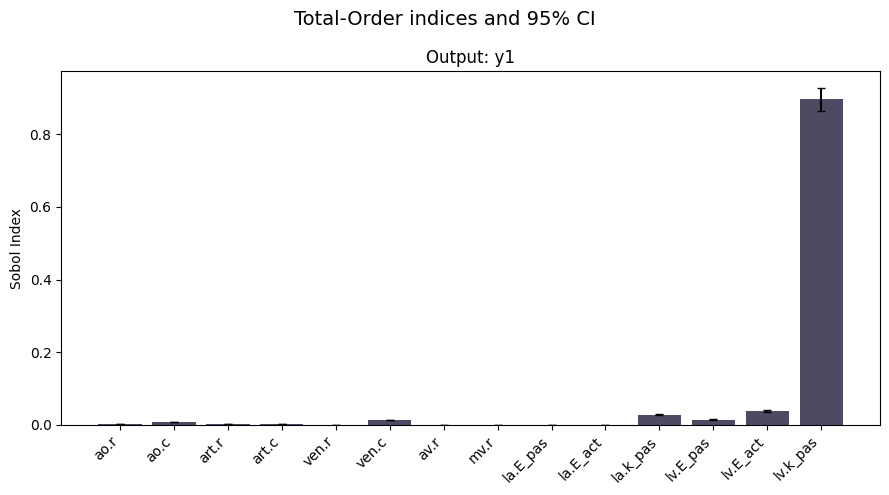

In [ ]:
sa.plot_sobol(sobol_df, index="ST", figsize=figsize) 

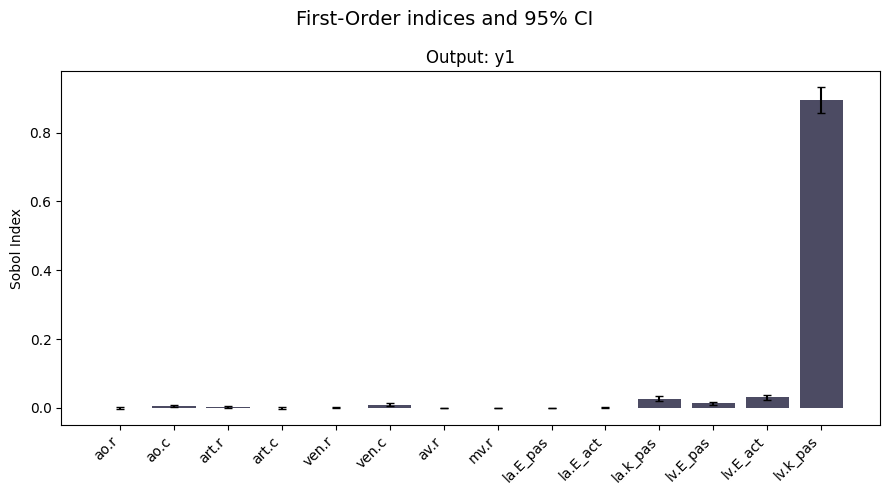

In [ ]:
sa.plot_sobol(sobol_df, index="S1", figsize=figsize) 